In [1]:
# import os and csv functions
import os
import csv
# import libaries
import pandas as pd
import numpy as np
from tabulate import tabulate
from datetime import datetime
from sklearn.impute import SimpleImputer
from tabula import read_pdf
import math
import seaborn as sns
import matplotlib.pyplot as plt
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangle

In [2]:
# getting the file from local
df=pd.read_csv('finalcsv.csv')
df=df.drop(columns=['Unnamed: 0'])

In [3]:
# handle the null values
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   full_state          3142 non-null   object 
 1   state               3142 non-null   object 
 2   county              3142 non-null   object 
 3   population          3142 non-null   int64  
 4   revenue_per_person  3142 non-null   int64  
 5   state_funding       3142 non-null   int64  
 6   funding             3142 non-null   int64  
 7   buildvalue          3142 non-null   float64
 8   agrivalue           3142 non-null   float64
 9   area                3142 non-null   float64
 10  risk_score          3142 non-null   float64
 11  resl_score          3142 non-null   float64
 12  resl_value          3142 non-null   float64
 13  drought_events      3142 non-null   float64
 14  drought_freq        3142 non-null   float64
 15  drought_score       3142 non-null   float64
 16  drough

In [4]:
cost=pd.read_csv('state-cost-data.csv')
cost['result'] = cost['state'].isin(df['state'])
cost=cost[cost.result==True]
df.replace('D.C.','DC',inplace=True)
df=pd.merge(df, cost, on='state', how='outer')
df.drop(columns=['result'],inplace=True)
df.funding=df.funding/1000000
df.state_funding=df.state_funding/1000000

# Exploration

### Background

The data has 3142 rows, and 25 columns. This project specifically focusing on the Severe Storm, Draught and Hurricane.

The project has included all 50 states' counties and the District of Columbia area. The risk score is combined with 16 different disasters and retrived it from Federal Emergency Management Agency. (FEMA)

Per National Centers for Environmental Information [(NOAA)](https://www.ncei.noaa.gov/access/billions/time-series).'During 2021, there were 20 separate billion-dollar weather and climate disaster events across the United States. The total cost from these events of 2021 was 152.6 billion and was the third most costly year on record, behind 2017 and 2005. The total costs for the last five complete years (788.4 billion) is more than one-third of the disaster cost total of the last 43-years (1980-2022), which exceeds 2.295 trillion (inflation-adjusted to 2022 dollars). This reflects a 5-year cost average of nearly 157.6 billion/year — a new record — as shown above by the black line.'

In this exploration we will going to dive deep into and find out a ultimate solution to lower the cost and project whether the state is ready for next disaster.

A research article "[U.S. Billion-dollar Weather and Climate Disasters: Data Sources, Trends, Accuracy and Biases](https://www.ncei.noaa.gov/monitoring-content/billions/docs/smith-and-katz-2013.pdf)" (Smith and Katz, 2013) regarding the loss data, the agency's methods and any potential bias was published in 2013. The research article found the net effect of all biases appears to be an underestimation of average loss. In particular, it is shown that the factor approach can result in an underestimation of average loss of roughly 10–15%. This bias was corrected during a reanalysis of the loss data to reflect new loss totals.

2022 is the eighth consecutive year (2015-2022) in which 10 or more billion-dollar weather and climate disaster events have impacted the United States. Over the last 43 years (1980-2022), the years with 10 or more separate billion-dollar disaster events include 1998, 2008, 2011-2013, and 2015-2022.

In [5]:
## Q1: Whether the dense of the population contributed to the overall funding available or the risk level

In [6]:
# set up th eenvironment
q1=df.groupby('state',as_index=False).agg(sum)
q1.head()

,state,population,revenue_per_person,state_funding,funding,buildvalue,agrivalue,area,risk_score,resl_score,...,storm_freq,storm_score,storm_loss,drought,flooding,freeze,severe storm,tropical cyclone,wildfire,winter storm
0,AK,710231,131167,3212.374813,3.949116e+05,9.066546e+10,7.045900e+07,570885.873384,178.187610,1368.088004,...,725.000000,636.550000,1.793073e+07,0.0,0.0,0.0,0.0,0.0,60755.0,0.0
1,AL,4779736,251652,17952.688416,3.664751e+06,5.026065e+11,5.880985e+09,50646.710922,735.184270,3552.503792,...,4908.518519,969.370011,3.081635e+07,426850.3,8535.8,9447.0,830444.9,1679844.1,45452.8,139065.2
2,AR,2915918,325200,12643.420448,2.203375e+06,2.909845e+11,9.434198e+09,52034.253918,967.625466,3939.446224,...,5528.185185,1116.088452,4.420145e+07,462105.0,326932.5,20685.0,538860.0,50077.5,0.0,67410.0
3,AZ,6392017,62040,26437.382312,1.455005e+06,6.314331e+11,2.548788e+09,113591.481348,355.172321,746.492802,...,453.185185,330.806800,9.055429e+06,18598.5,9306.0,0.0,76380.0,0.0,18244.5,0.0
4,CA,37253956,406058,260814.945956,2.266709e+07,3.848852e+12,2.885307e+10,155785.519365,1629.518310,3065.076596,...,95.777778,480.144387,6.463715e+07,786056.6,777809.0,830966.0,189138.0,0.0,5296287.4,0.0


In [7]:
# bin the risk level to identify whether the funding available also associate with 
q1['risk_bin'] = pd.qcut(q1.risk_score, 4, labels=['low', 'median', 'hight', 'extremely_high'])
q1['pop_bin'] = pd.qcut(q1.population, 4, labels=['low', 'median', 'hight', 'extremely_high'])

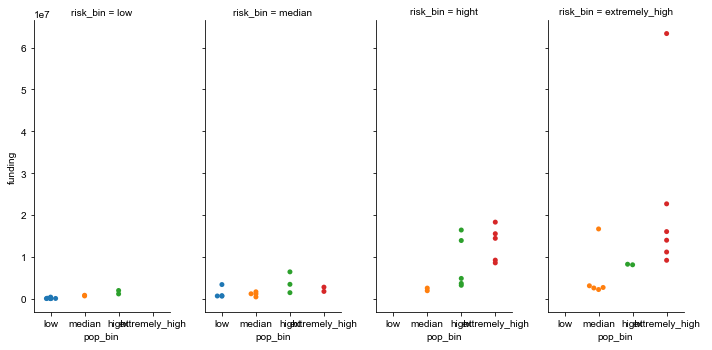

In [8]:
rc=sns.catplot(
    data=q1, kind="swarm",
    x="pop_bin", y="funding", col="risk_bin",
    aspect=.5
)
sns.set(rc={'figure.figsize':(21.7,18.27)})
plt.show()

### q1 key takeaway
- The population level has little impact on funding, but the risk level has significant impact on the funding.
- when the risk level is high and the population level is high; those two toghether will lead the funding to be high

### q2 the cost of the disaster per state per risk level

In [9]:
q2 = df.copy()

In [10]:
q2.columns

Index(['full_state', 'state', 'county', 'population', 'revenue_per_person',
       'state_funding', 'funding', 'buildvalue', 'agrivalue', 'area',
       'risk_score', 'resl_score', 'resl_value', 'drought_events',
       'drought_freq', 'drought_score', 'drought_loss', 'hurricane_events',
       'hurricane_freq', 'hurricane_score', 'hurricane_loss', 'storm_events',
       'storm_freq', 'storm_score', 'storm_loss', 'drought', 'flooding',
       'freeze', 'severe storm', 'tropical cyclone', 'wildfire',
       'winter storm'],
      dtype='object')

In [11]:
q2['total_cost']=q2['drought']+q2['flooding']+q2['freeze']+q2['severe storm']+q2['tropical cyclone']+q2['wildfire']+q2['winter storm']

In [12]:
q2['risk_bin'] = pd.qcut(q2.risk_score, 4, labels=['low', 'median', 'hight', 'extremely_high'])

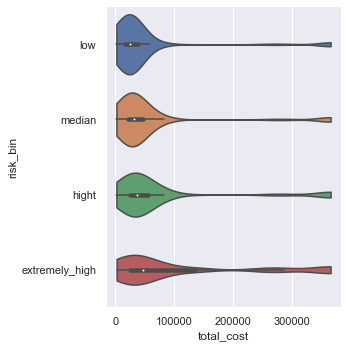

In [13]:
sns.catplot(
    data=q2, x="total_cost", y="risk_bin",
    kind="violin", bw=.25, cut=0, split=True,
)

### q3 how is the risk level in region, and whether the funding is sufficiently covered the total cost

In [14]:
q3=df.copy()

In [15]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE','DC']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']
west_dict = {i:"west" for i in west}
midwest_dict = {i:"midwest" for i in midwest}
south_dict = {i:"south" for i in south}
northeast_dict = {i:"northeast" for i in northeast}
d = {**west_dict, **midwest_dict, **south_dict, **northeast_dict}
q3['Region'] = q3['state'].map(d)

In [16]:
q3['risk_bin'] = pd.qcut(q3.risk_score, 4, labels=['low', 'median', 'hight', 'extremely_high'])
q3['avg_cost']=(q3['drought']+q3['flooding']+q3['freeze']+q3['severe storm']+q3['tropical cyclone']+q3['wildfire']+q3['winter storm'])/43

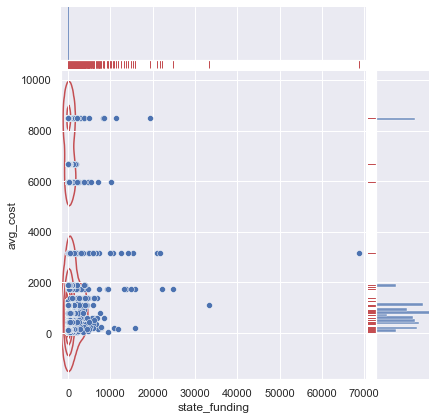

In [19]:
g = sns.jointplot(data=q3, x="state_funding", y="avg_cost")
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)

### which region is most save to live

In [20]:
q4=df.copy()

In [22]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE','DC']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']
west_dict = {i:"west" for i in west}
midwest_dict = {i:"midwest" for i in midwest}
south_dict = {i:"south" for i in south}
northeast_dict = {i:"northeast" for i in northeast}
d = {**west_dict, **midwest_dict, **south_dict, **northeast_dict}
q4['Region'] = q4['state'].map(d)

<AxesSubplot:xlabel='Region', ylabel='risk_score'>

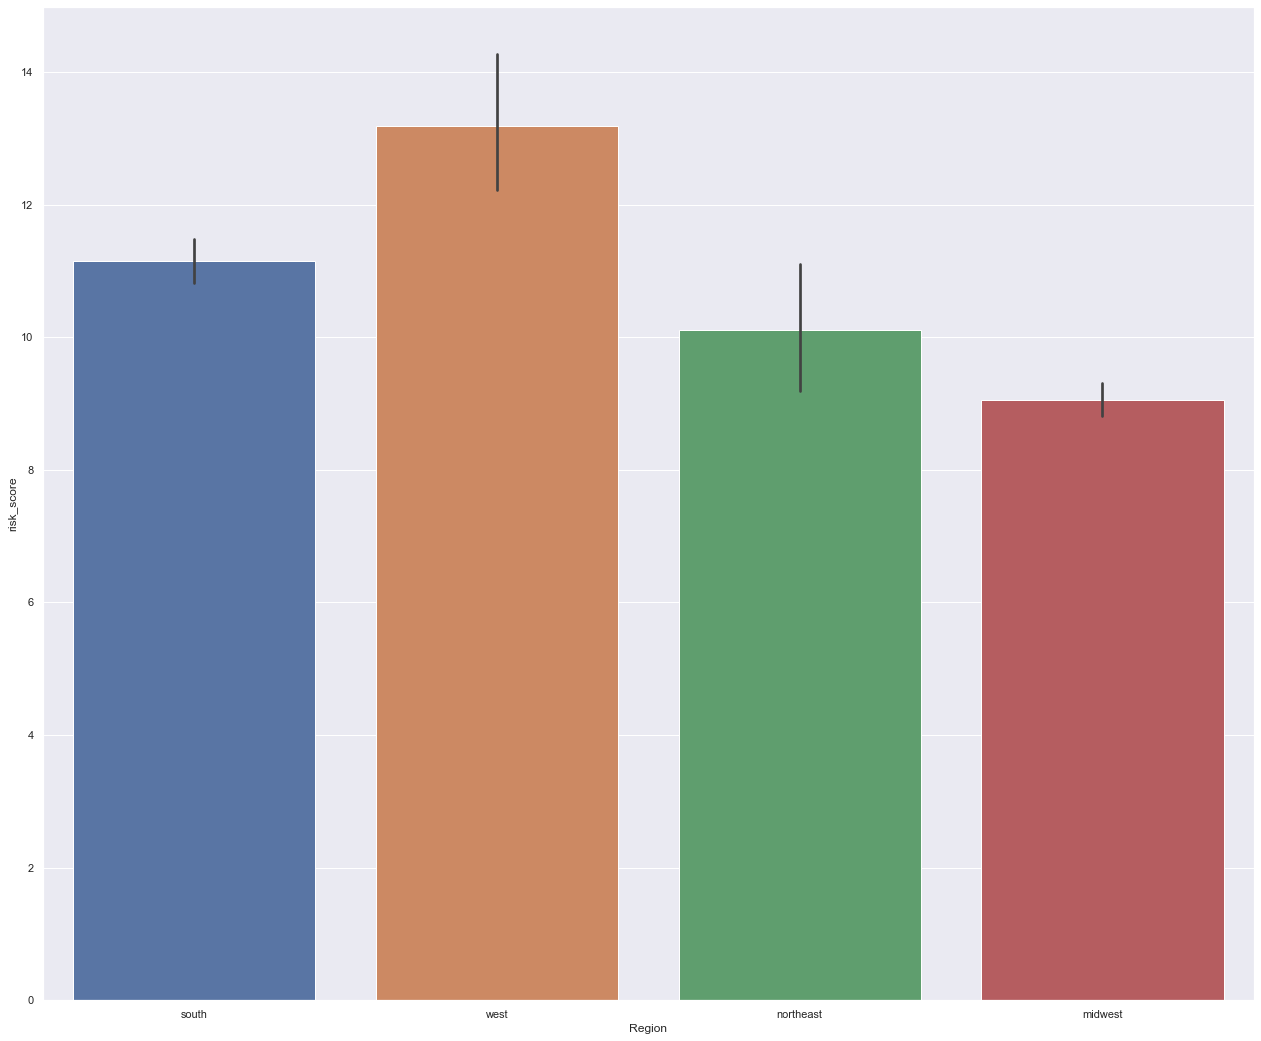

In [38]:
sns.barplot(data=q4, x="Region", y="risk_score")

### q5 which is storm vs drought disaster per region

In [39]:
q5=df.copy()

In [40]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE','DC']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']
west_dict = {i:"west" for i in west}
midwest_dict = {i:"midwest" for i in midwest}
south_dict = {i:"south" for i in south}
northeast_dict = {i:"northeast" for i in northeast}
d = {**west_dict, **midwest_dict, **south_dict, **northeast_dict}
q5['Region'] = q5['state'].map(d)

In [43]:
q5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   full_state          3142 non-null   object 
 1   state               3142 non-null   object 
 2   county              3142 non-null   object 
 3   population          3142 non-null   int64  
 4   revenue_per_person  3142 non-null   int64  
 5   state_funding       3142 non-null   float64
 6   funding             3142 non-null   float64
 7   buildvalue          3142 non-null   float64
 8   agrivalue           3142 non-null   float64
 9   area                3142 non-null   float64
 10  risk_score          3142 non-null   float64
 11  resl_score          3142 non-null   float64
 12  resl_value          3142 non-null   float64
 13  drought_events      3142 non-null   float64
 14  drought_freq        3142 non-null   float64
 15  drought_score       3142 non-null   float64
 16  drough

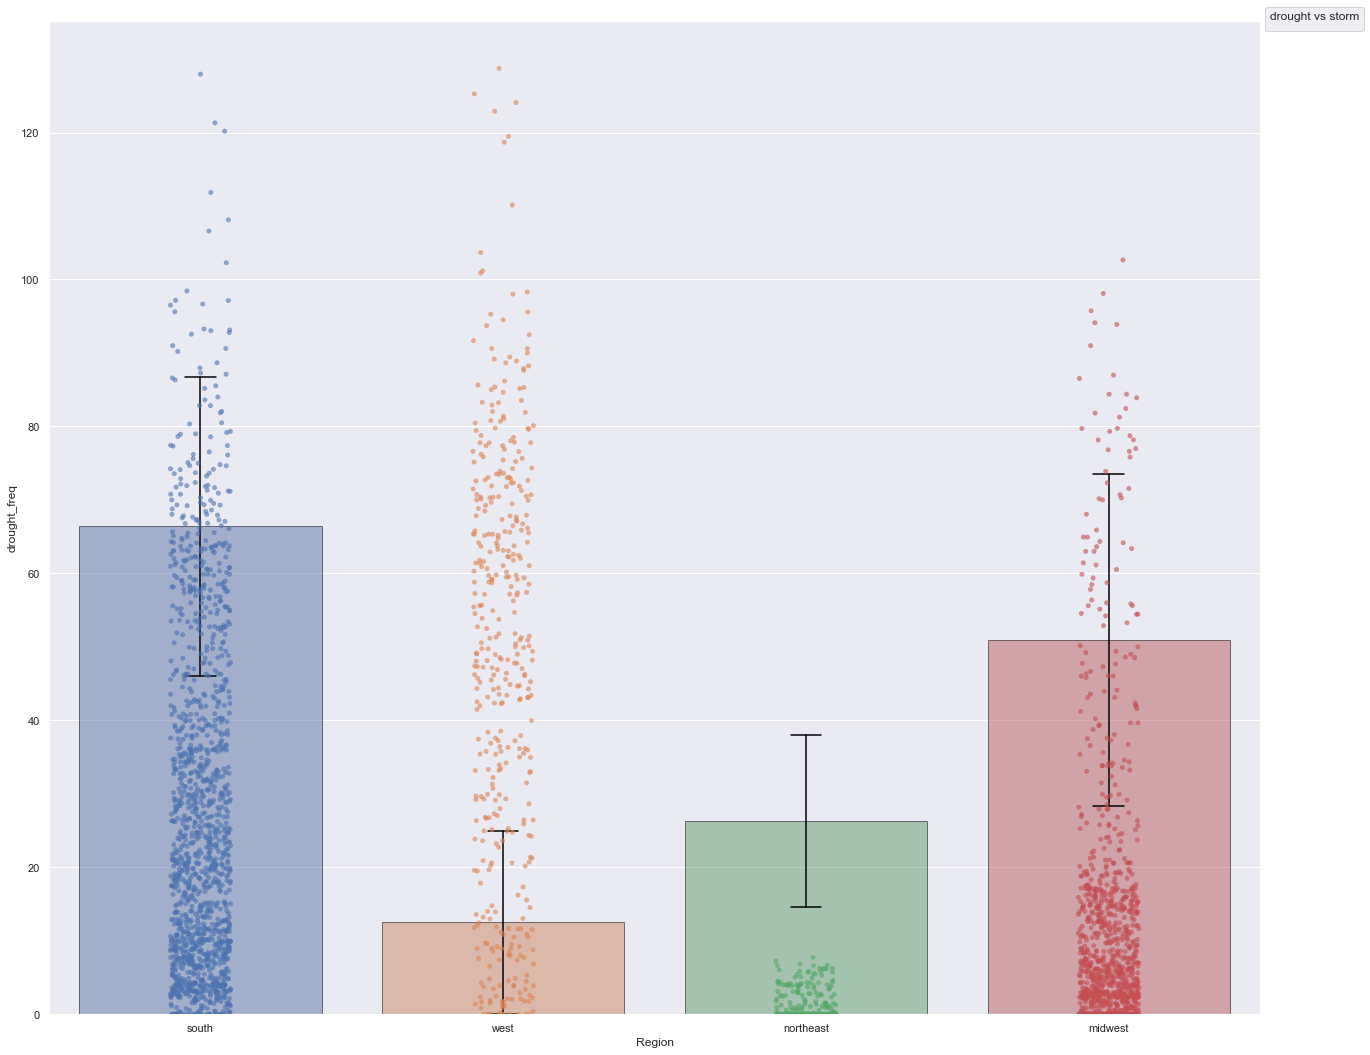

In [62]:
ax = sns.barplot(
    x="Region", 
    y="storm_freq",  
    data=q5, 
    ci="sd", 
    edgecolor="black",
    errcolor="black",
    errwidth=1.5,
    capsize = 0.1,
    alpha=0.5
)

sns.stripplot(
    x="Region", 
    y="drought_freq",  
    data=q5, dodge=True, alpha=0.6, ax=ax
)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title='drought vs storm', bbox_to_anchor=(1, 1.02), loc='upper left')

## q6 most common disaster

In [64]:
q6=df.copy()

In [96]:
q6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   full_state          3142 non-null   object 
 1   state               3142 non-null   object 
 2   county              3142 non-null   object 
 3   population          3142 non-null   int64  
 4   revenue_per_person  3142 non-null   int64  
 5   state_funding       3142 non-null   float64
 6   funding             3142 non-null   float64
 7   buildvalue          3142 non-null   float64
 8   agrivalue           3142 non-null   float64
 9   area                3142 non-null   float64
 10  risk_score          3142 non-null   float64
 11  resl_score          3142 non-null   float64
 12  resl_value          3142 non-null   float64
 13  drought_events      3142 non-null   float64
 14  drought_freq        3142 non-null   float64
 15  drought_score       3142 non-null   float64
 16  drough

In [67]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE','DC']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']
west_dict = {i:"west" for i in west}
midwest_dict = {i:"midwest" for i in midwest}
south_dict = {i:"south" for i in south}
northeast_dict = {i:"northeast" for i in northeast}
d = {**west_dict, **midwest_dict, **south_dict, **northeast_dict}
q6['Region'] = q6['state'].map(d)
q6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   full_state          3142 non-null   object 
 1   state               3142 non-null   object 
 2   county              3142 non-null   object 
 3   population          3142 non-null   int64  
 4   revenue_per_person  3142 non-null   int64  
 5   state_funding       3142 non-null   float64
 6   funding             3142 non-null   float64
 7   buildvalue          3142 non-null   float64
 8   agrivalue           3142 non-null   float64
 9   area                3142 non-null   float64
 10  risk_score          3142 non-null   float64
 11  resl_score          3142 non-null   float64
 12  resl_value          3142 non-null   float64
 13  drought_events      3142 non-null   float64
 14  drought_freq        3142 non-null   float64
 15  drought_score       3142 non-null   float64
 16  drough

In [123]:
a1=pd.DataFrame((q6.Region,q6.storm_score,q6.drought_score,q6.hurricane_score)).T

In [124]:
dfl = (a1.melt(id_vars='Region', var_name='freq', value_name='values')
       .sort_values('values', ascending=False).reset_index(drop=True))

In [125]:
dfl

,Region,freq,values
0,south,hurricane_score,100.0
1,west,drought_score,100.0
2,south,hurricane_score,81.137275
3,south,hurricane_score,80.13862
4,west,drought_score,78.878531
...,...,...,...
9421,west,drought_score,0.0
9422,west,drought_score,0.0
9423,south,drought_score,0.0
9424,west,drought_score,0.0


<AxesSubplot:xlabel='Region', ylabel='values'>

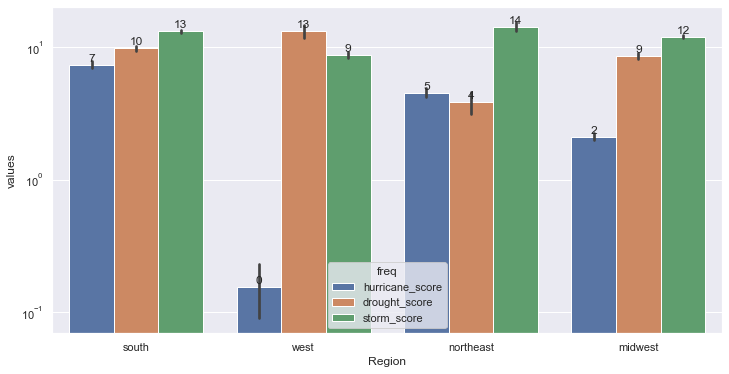

In [126]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='Region', y='values', data=dfl, hue='freq', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yscale('log')

for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)
    
# pad the spacing between the number and the edge of the figure
ax